In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, sys
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import statsmodels.stats.api as sms

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')

In [4]:
from ccs_tools import core_dtypes_pd

In [5]:
from utils import preprocess

Using TensorFlow backend.


## Prepare hyper-parameters and generate the .sh files

In [2]:
!rm hypertune*.sh

In [3]:
cohorts = ['ami']
tst_seeds = range(3)
eval_datas = ['tst']
resample_fracs = [1., 0.1, 0.03]

In [4]:
para_itr = itertools.product(cohorts, tst_seeds, eval_datas, resample_fracs)
para_lst = list(para_itr)

In [5]:
len(para_lst)

9

In [13]:
n_jobs = 8
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python recycle_pred.py --cohort {} --tst_seed {} --eval_data {} --resample_frac {} --job_index {}\n'.format(*para, job_ind))

In [107]:
job_index = 5
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_all0827.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --tst_seed {9} --cohort {10} --sep_dx1 {11} --val_fold {12} --result_file {13} --job_index {14}\n'.format(*para, job_index))

## Inference

In [33]:
!rm hypertune*.sh

In [29]:
cohorts = ['ami']
split_seeds = [2, 3]
train_idxs = [1, 2]
sample_seeds = range(10)
n_vals = [10]

In [30]:
para_itr = itertools.product(cohorts, split_seeds, train_idxs, sample_seeds, n_vals)
para_lst = list(para_itr)

In [31]:
len(para_lst)

40

In [34]:
n_jobs = 11
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python inference_noresample.py --cohort {} --split_seed {} --train_idx {} --sample_seed {} --n_val {} --job_index {}\n'.format(*para, job_ind))

In [107]:
job_index = 5
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_all0827.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --tst_seed {9} --cohort {10} --sep_dx1 {11} --val_fold {12} --result_file {13} --job_index {14}\n'.format(*para, job_index))

## Result Analysis

In [5]:
from sklearn.metrics import cohen_kappa_score
from scipy.stats import spearmanr

In [6]:
cohort = 'ami'
split_seed = 3
train_idx = 2
sample_seed = 0
n_val = 10

In [7]:
auc = pd.read_csv(path+'cohorts30/{}/inference/auc_nosample_{}{}_{}.csv'.format(cohort, split_seed, train_idx, sample_seed))

In [8]:
auc

,auc0,auc1,auc2,auc3,auc4,auc5,auc6,auc7,auc8,auc9,auc_avg
0,0.714741,0.712592,0.71549,0.714946,0.71427,0.714449,0.714514,0.714638,0.715067,0.714497,0.717194


In [11]:
recyc_pred = pd.read_csv(path+'cohorts30/{}/inference/recyc_pred_nosample_{}{}_{}.csv'.format(cohort, split_seed, train_idx, sample_seed))

In [12]:
recyc_pred.head()

,recycle_pred0,recycle_pred1,recycle_pred2,recycle_pred3,recycle_pred4,recycle_pred5,recycle_pred6,recycle_pred7,recycle_pred8,recycle_pred9,recyc_mean,HOSP_NRD
0,0.115522,0.122610,0.125812,0.116358,0.113503,0.118303,0.119154,0.126736,0.102817,0.135186,0.119600,11006.0
1,0.116178,0.109845,0.116532,0.121698,0.122348,0.116459,0.114815,0.122146,0.114690,0.124633,0.117934,11010.0
2,0.124341,0.119005,0.127408,0.116914,0.127239,0.120774,0.119682,0.130957,0.117785,0.125158,0.122926,11011.0
3,0.141895,0.155645,0.135620,0.138936,0.151126,0.155298,0.140310,0.139006,0.162380,0.163113,0.148333,11013.0
4,0.123854,0.120909,0.126746,0.115191,0.118059,0.122579,0.122299,0.120929,0.118270,0.126494,0.121533,11014.0


In [93]:
auc_lst = []
for sample_seed in range(10):
    auc = pd.read_csv(path+'cohorts30/{}/inference/auc_nosample_{}{}_{}.csv'.format(cohort, split_seed, train_idx, sample_seed))
    auc_lst.append(auc.auc_avg.values[0])

In [94]:
auc_lst

[0.7173414409101583,
 0.7173108231760615,
 0.7172103738259566,
 0.7174504487813136,
 0.7172707846409037,
 0.7174601115433716,
 0.7170553593967826,
 0.7173739551376843,
 0.7173693725113737,
 0.7175628263382315]

In [102]:
recyc_preds = pd.DataFrame()
for sample_seed in range(10):
    recyc_pred = pd.read_csv(path+'cohorts30/{}/inference/recyc_pred_group_{}{}_{}.csv'.format(cohort, split_seed, train_idx, 
                                                                                         sample_seed))
    val_avg = recyc_pred[['HOSP_NRD', 'recyc_mean']]
    val_avg.columns = ['HOSP_NRD', 'recyc_pred'+str(sample_seed)]
    try:
        recyc_preds = pd.merge(recyc_preds, val_avg, on='HOSP_NRD')
    except KeyError:
        recyc_preds = val_avg

In [95]:
recyc_preds = pd.DataFrame()
for sample_seed in range(10):
    recyc_pred = pd.read_csv(path+'cohorts30/{}/inference/recyc_pred_nosample_{}{}_{}.csv'.format(cohort, split_seed, train_idx, 
                                                                                         sample_seed))
    to_merge = recyc_pred[['HOSP_NRD']+ ['recycle_pred'+str(j) for j in range(n_val)]]
    to_merge.columns = ['HOSP_NRD']+ ['recycle_pred'+str(sample_seed)+'_'+str(j) for j in range(n_val)]
    try:
        recyc_preds = pd.merge(recyc_preds, to_merge, on='HOSP_NRD')
    except KeyError:
        recyc_preds = to_merge.copy()

In [15]:
recyc_preds.shape

(874, 101)

In [16]:
hosp_df = recyc_preds.set_index(recyc_preds.HOSP_NRD).drop(columns=['HOSP_NRD']).transpose()

In [49]:
hosp_freq.index[0]

12245.0

In [66]:
recyc_preds.loc[recyc_preds.recyc_mean==recyc_preds.recyc_mean.max()]

,HOSP_NRD,recycle_pred0_0,recycle_pred0_1,recycle_pred0_2,recycle_pred0_3,recycle_pred0_4,recycle_pred0_5,recycle_pred0_6,recycle_pred0_7,recycle_pred0_8,...,recycle_pred9_15,recycle_pred9_16,recycle_pred9_17,recycle_pred9_18,recycle_pred9_19,recyc_mean,recyc_std,upper,lower,rank
3,11013.0,0.144917,0.134876,0.143931,0.124025,0.140978,0.137928,0.133959,0.125084,0.155603,...,0.124943,0.124807,0.149169,0.14437,0.192865,0.136793,0.014973,0.16614,0.107447,873


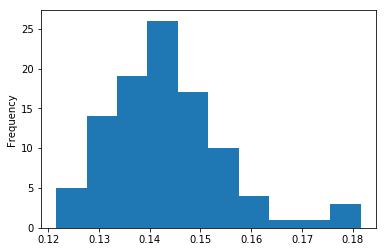

In [17]:
hosp_df[11013].plot.hist()

In [7]:
train_df = pd.read_csv(path+'cohorts30/{}/inference/index_split{}_{}.csv'.format(cohort, split_seed, train_idx), dtype=core_dtypes_pd)

In [8]:
hosp_freq = train_df.HOSP_NRD.value_counts()

In [ ]:
recyc_preds = recyc_preds.assign(N=recyc_preds.HOSP_NRD.apply(lambda x:hosp_freq[x]))

pred_cols = recyc_preds.columns[1:-1]

recyc_preds = recyc_preds.assign(recyc_mean=recyc_preds[pred_cols].mean(axis=1))
recyc_preds = recyc_preds.assign(recyc_std=recyc_preds[pred_cols].std(axis=1))

recyc_preds = recyc_preds.assign(upper = recyc_preds.recyc_mean + 1.96*recyc_preds.recyc_std)
recyc_preds = recyc_preds.assign(lower = recyc_preds.recyc_mean - 1.96*recyc_preds.recyc_std)
recyc_preds = recyc_preds.sort_values('recyc_mean')
recyc_preds = recyc_preds.assign(rank = range(len(recyc_preds)))

recyc_preds = recyc_preds.assign(lower = recyc_preds[pred_cols].quantile(0.025, axis=1))
recyc_preds = recyc_preds.assign(upper = recyc_preds[pred_cols].quantile(0.975, axis=1))

In [ ]:
recyc_preds = recyc_preds.assign(recyc_mean=recyc_preds[['recyc_pred'+str(j) for j in range(10)]].mean(axis=1))
recyc_preds = recyc_preds.assign(recyc_std=recyc_preds[['recyc_pred'+str(j) for j in range(10)]].std(axis=1))

recyc_preds = recyc_preds.assign(upper = recyc_preds.recyc_mean + 1.96*recyc_preds.recyc_std)
recyc_preds = recyc_preds.assign(lower = recyc_preds.recyc_mean - 1.96*recyc_preds.recyc_std)
recyc_preds = recyc_preds.sort_values('recyc_mean')
recyc_preds = recyc_preds.assign(rank = range(len(recyc_preds)))

In [83]:
national_mean = recyc_preds.mean(axis=0)['recyc_mean']

In [100]:
national_mean = train_df.readm30.mean()

In [81]:
national_mean = (recyc_preds['recyc_mean'].values*recyc_preds['N']).sum()/(recyc_preds['N'].sum())

In [101]:
national_mean

0.12483313220201415

In [102]:
recyc_preds = recyc_preds.assign(outlier='not_outlier')

recyc_preds.loc[recyc_preds.upper<national_mean, 'outlier'] = 'good'

recyc_preds.loc[recyc_preds.lower>national_mean, 'outlier'] = 'bad'

In [36]:
recyc_preds.head()

,HOSP_NRD,recycle_pred0_0,recycle_pred0_1,recycle_pred0_2,recycle_pred0_3,recycle_pred0_4,recycle_pred0_5,recycle_pred0_6,recycle_pred0_7,recycle_pred0_8,...,recycle_pred9_7,recycle_pred9_8,recycle_pred9_9,N,recyc_mean,recyc_std,upper,lower,rank,outlier
527,12842.0,0.094518,0.094653,0.099849,0.104156,0.105102,0.097305,0.104226,0.115235,0.095484,...,0.112800,0.092097,0.100193,35,0.102625,0.013239,0.124062,0.074529,0,not_outlier
195,11682.0,0.103031,0.087307,0.102525,0.114081,0.112974,0.103600,0.098442,0.111341,0.108624,...,0.111210,0.083054,0.094333,31,0.103789,0.013132,0.122882,0.075309,1,not_outlier
422,12434.0,0.107128,0.082844,0.106550,0.120399,0.106921,0.098815,0.105882,0.114537,0.102025,...,0.108081,0.090098,0.109402,40,0.104418,0.012889,0.123864,0.079697,2,not_outlier
121,11399.0,0.098839,0.103220,0.102149,0.112049,0.105402,0.104145,0.102054,0.111949,0.102673,...,0.120328,0.101958,0.105918,98,0.105376,0.011170,0.123346,0.082352,3,not_outlier
44,11152.0,0.105931,0.089567,0.112052,0.117344,0.110584,0.100401,0.099459,0.109667,0.103641,...,0.110256,0.100565,0.094604,30,0.106052,0.011532,0.124281,0.082326,4,not_outlier


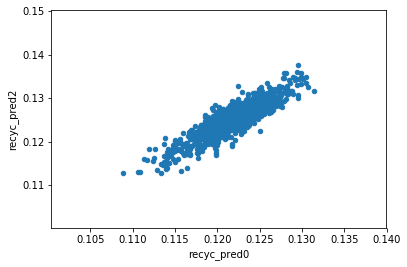

In [149]:
recyc_preds.plot.scatter('recyc_pred0', 'recyc_pred2')

In [21]:
recyc_preds.recyc_std.mean()*1.96*2

0.034058426127354484

In [103]:
recyc_preds.outlier.value_counts()

not_outlier    869
bad              4
good             1
Name: outlier, dtype: int64

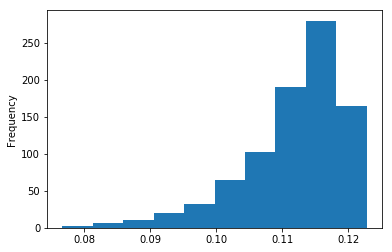

In [29]:
recyc_preds.lower.plot.hist()

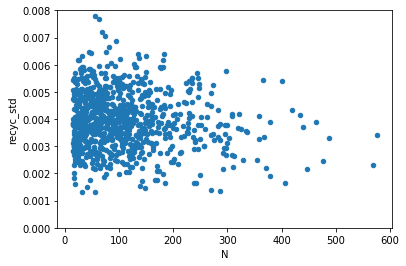

In [108]:
recyc_preds.plot.scatter('N', 'recyc_std', ylim=(0, 0.008))

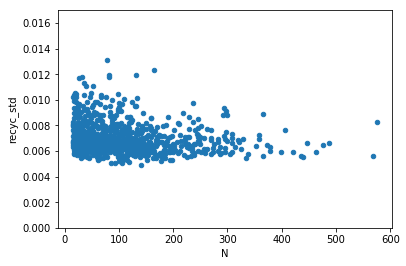

In [89]:
recyc_preds.plot.scatter('N', 'recyc_std', ylim=(0, 0.017))

In [38]:
cohort='ami'
split_seed = 3
n_val = 20
for train_idx in [1, 2]:
    recyc_preds = pd.DataFrame()
    for sample_seed in range(10):
        recyc_pred = pd.read_csv(path+'cohorts30/{}/inference/recyc_pred_{}{}_{}.csv'.format(cohort, split_seed, train_idx, 
                                                                                         sample_seed))
        to_merge = recyc_pred[['HOSP_NRD']+ ['recycle_pred'+str(j) for j in range(n_val)]]
        to_merge.columns = ['HOSP_NRD']+ ['recycle_pred'+str(sample_seed)+'_'+str(j) for j in range(n_val)]
        try:
            recyc_preds = pd.merge(recyc_preds, to_merge, on='HOSP_NRD')
        except KeyError:
            recyc_preds = to_merge.copy()
    recyc_preds = recyc_preds.assign(N=recyc_preds.HOSP_NRD.apply(lambda x:hosp_freq[x]))
    pred_cols = recyc_preds.columns[1:-1]
    recyc_preds = recyc_preds.assign(recyc_mean=recyc_preds[pred_cols].mean(axis=1))
    recyc_preds = recyc_preds.assign(recyc_std=recyc_preds[pred_cols].std(axis=1))
    recyc_preds = recyc_preds.sort_values('recyc_mean')
    recyc_preds = recyc_preds.assign(rank = range(len(recyc_preds)))
    recyc_preds = recyc_preds.assign(lower = recyc_preds[pred_cols].quantile(0.025, axis=1))
    recyc_preds = recyc_preds.assign(upper = recyc_preds[pred_cols].quantile(0.975, axis=1))
    national_mean = (recyc_preds['recyc_mean'].values*recyc_preds['N']).sum()/(recyc_preds['N'].sum())
    recyc_preds = recyc_preds.assign(outlier='not_outlier')
    recyc_preds.loc[recyc_preds.upper<national_mean, 'outlier'] = 'good'
    recyc_preds.loc[recyc_preds.lower>national_mean, 'outlier'] = 'bad'
    
    to_merge = recyc_preds[['HOSP_NRD', 'recyc_mean', 'outlier', 'rank']].copy()
    to_merge.columns = ['HOSP_NRD', 'recyc_mean'+str(train_idx), 'outlier'+str(train_idx), 'rank'+str(train_idx)]
    if train_idx==1:
        DL_compare = to_merge.copy()
    else:
        DL_compare = pd.merge(DL_compare, to_merge, on='HOSP_NRD')        

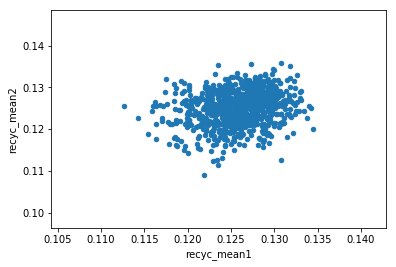

In [39]:
DL_compare.plot.scatter('recyc_mean1', 'recyc_mean2')

In [40]:
n_sub = 1
topbottom = DL_compare.loc[(DL_compare.rank1<n_sub)|(DL_compare.rank1>=len(DL_compare)-n_sub)|
                           (DL_compare.rank2<n_sub)|(DL_compare.rank2>=len(DL_compare)-n_sub)]

In [33]:
topbottom

,HOSP_NRD,recyc_mean1,outlier1,rank1,recyc_mean2,outlier2,rank2
0,13344.0,0.105104,good,0,0.123816,not_outlier,282
293,14053.0,0.123099,not_outlier,293,0.101659,good,0
837,11984.0,0.134195,not_outlier,837,0.141403,not_outlier,873
873,13386.0,0.138605,not_outlier,873,0.117512,not_outlier,77


In [41]:
np.mean(np.abs(topbottom.rank1 - topbottom.rank2))/len(DL_compare)

0.3890160183066362

In [42]:
mean_change = []
for n_sub in range(1, 400, 10):
    topbottom = DL_compare.loc[(DL_compare.rank1<n_sub)|(DL_compare.rank1>=len(DL_compare)-n_sub)|
                           (DL_compare.rank2<n_sub)|(DL_compare.rank2>=len(DL_compare)-n_sub)]
    mean_change.append(np.mean(np.abs(topbottom.rank1 - topbottom.rank2))/len(DL_compare))

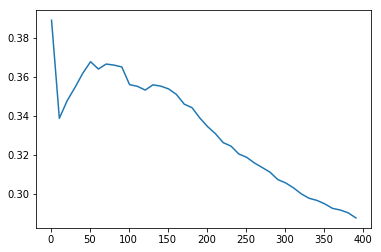

In [43]:
plt.plot(range(1, 400, 10), mean_change)

In [44]:
spearmanr(DL_compare.recyc_mean1, DL_compare.recyc_mean2)

SpearmanrResult(correlation=0.23123212783190608, pvalue=4.508684724562272e-12)

In [108]:
np.corrcoef(DL_compare.recyc_mean1, DL_compare.recyc_mean2)

array([[1.        , 0.19231556],
       [0.19231556, 1.        ]])

In [110]:
cohen_kappa_score(DL_compare.outlier1, DL_compare.outlier2)

-0.005671077504725952

In [109]:
pd.crosstab(DL_compare.outlier1, DL_compare.outlier2, margins=True)

outlier2,bad,good,not_outlier,All
outlier1,,,,
bad,0,0,5,5
good,0,0,4,4
not_outlier,4,1,860,865
All,4,1,869,874


In [113]:
DL_compare.loc[DL_compare['outlier2']=='good']

,HOSP_NRD,recyc_mean1,outlier1,rank1,recyc_mean2,outlier2,rank2
293,14053.0,0.123099,not_outlier,293,0.101659,good,0


In [114]:
DL_compare.loc[DL_compare['outlier2']=='bad']

,HOSP_NRD,recyc_mean1,outlier1,rank1,recyc_mean2,outlier2,rank2
190,13180.0,0.121285,not_outlier,190,0.139383,bad,867
801,12397.0,0.132567,not_outlier,801,0.138180,bad,865
828,13000.0,0.133446,not_outlier,828,0.141179,bad,872
837,11984.0,0.134195,not_outlier,837,0.141403,bad,873


### Normalizing

In [176]:
recyc_renorm = recyc_preds[['HOSP_NRD', 'N']+['recyc_pred'+str(j) for j in range(10)]].copy()

for j in range(10):
    recyc_renorm['recyc_pred'+str(j)] = recyc_renorm['recyc_pred'+str(j)] - recyc_renorm['recyc_pred'+str(j)].mean()

recyc_renorm = recyc_renorm.assign(recyc_mean=recyc_renorm[['recyc_pred'+str(j) for j in range(10)]].mean(axis=1))
recyc_renorm = recyc_renorm.assign(recyc_std=recyc_renorm[['recyc_pred'+str(j) for j in range(10)]].std(axis=1))
recyc_renorm = recyc_renorm.assign(upper = recyc_renorm.recyc_mean + 1.96*recyc_renorm.recyc_std)
recyc_renorm = recyc_renorm.assign(lower = recyc_renorm.recyc_mean - 1.96*recyc_renorm.recyc_std)

recyc_renorm['outlier'] = 'not_outlier'
recyc_renorm.loc[recyc_renorm.upper<0, 'outlier'] = 'good'
recyc_renorm.loc[recyc_renorm.lower>0, 'outlier'] = 'bad'

In [95]:
to_merge = recyc_renorm[['HOSP_NRD', 'recyc_mean', 'outlier']].copy()

to_merge.columns = ['HOSP_NRD', 'recyc_mean'+str(train_idx), 'outlier'+str(train_idx)]

NameError: name 'recyc_renorm' is not defined

In [172]:
DL_compare = to_merge.copy()

In [178]:
DL_compare = pd.merge(DL_compare, to_merge, on='HOSP_NRD')

In [161]:
recyc_renorm['outlier'].value_counts()

not_outlier    455
bad            221
good           198
Name: outlier, dtype: int64

In [73]:
recyc_renorm.head()

,HOSP_NRD,N,recyc_pred0,recyc_pred1,recyc_pred2,recyc_pred3,recyc_pred4,recyc_pred5,recyc_pred6,recyc_pred7,recyc_pred8,recyc_pred9,recyc_mean,recyc_std,upper,lower,outlier
0,11006.0,88,-0.008381,-0.008994,-0.007248,-0.009039,-0.009801,-0.007368,-0.007933,-0.010241,-0.006755,-0.007229,-0.008299,0.001188,-0.005971,-0.010627,good
1,11010.0,208,-0.014354,-0.016875,-0.015778,-0.015510,-0.017006,-0.012171,-0.014656,-0.017332,-0.014268,-0.016473,-0.015442,0.001603,-0.012300,-0.018584,good
2,11011.0,36,-0.003125,-0.004833,-0.004819,-0.004986,-0.004375,-0.003862,-0.006959,-0.006972,-0.006532,-0.005258,-0.005172,0.001295,-0.002633,-0.007711,good
3,11013.0,230,0.004218,0.007364,0.006275,0.005769,0.008090,0.004522,0.007124,0.007819,0.008742,0.007319,0.006724,0.001502,0.009668,0.003780,bad
4,11014.0,308,-0.003024,-0.001799,-0.005184,-0.003897,-0.002025,-0.003873,-0.000971,-0.000954,0.000529,-0.004333,-0.002553,0.001803,0.000981,-0.006088,not_outlier


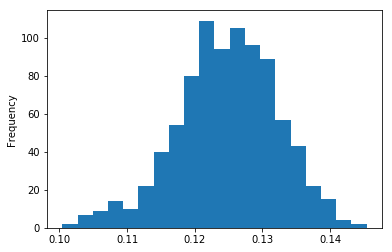

In [64]:
recyc_pred.recyc_mean.plot.hist(bins=20)

### Diagnosis

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
    
from keras.layers import Input, Embedding, Concatenate, Reshape, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd
from setsum_layer import MaskedSum, MaskedDense

In [104]:
cohort = 'ami'
train_idx = 2
split_seed = 0
sample_seed = 0
n_val = 1

job_index = 7

In [105]:
all_df = pd.read_csv(path+'cohorts30/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)
train_df0 = pd.read_csv(path+'cohorts30/{}/inference/index_split{}_{}.csv'.format(cohort, split_seed, train_idx), dtype=core_dtypes_pd)
train_df0 = train_df0.reset_index(drop=True)
tst_df = pd.read_csv(path+'cohorts30/{}/inference/index_split{}_{}.csv'.format(cohort, split_seed, 3-train_idx), dtype=core_dtypes_pd)
#index_df = train_df0.sample(frac=0.1, random_state=24)

In [97]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)*2 + sorted(pr_multi.ICD9CM_CODE) + sorted(dx_ccs_cat)[1:]*2 + sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)    
dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 
                                             1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))

hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

n_DX = 29
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [106]:
age_mean = all_df['AGE'].mean()
age_std = all_df['AGE'].std()
los_mean = all_df['LOS'].mean()
los_std = all_df['LOS'].std()
n_pay1 = int(all_df['PAY1'].max())+1
n_ed = int(all_df['HCUP_ED'].max())+1
n_zipinc = int(all_df['ZIPINC_QRTL'].max())+1

DX1_array_tst = tst_df.DX1.map(DX1_dict).values
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)
DX_mat_tst = DX_df_tst.values
PR_df_tst = tst_df[PRs]
PR_df_tst = PR_df_tst.fillna('missing')
PR_df_tst[PR_df_tst.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df_tst[pr] = PR_df_tst[pr].map(PR_dict)
PR_mat_tst = PR_df_tst.values
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat_tst = to_categorical(tst_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [113]:
DX1_array_index = index_df.DX1.map(DX1_dict).values
DX_df_index = index_df[DXs]
DX_df_index = DX_df_index.fillna('missing')
DX_df_index[DX_df_index.isin(['invl', 'incn'])] = 'missing'
DX_df_index[DX_df_index.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df_index[dx] = DX_df_index[dx].map(DX_dict)
DX_mat_index = DX_df_index.values
PR_df_index = index_df[PRs]
PR_df_index = PR_df_index.fillna('missing')
PR_df_index[PR_df_index.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df_index[pr] = PR_df_index[pr].map(PR_dict)
PR_mat_index = PR_df_index.values
demo_mat_index = index_df[['AGE', 'FEMALE']].values
demo_mat_index[:, 0] = (demo_mat_index[:, 0]-age_mean)/age_std
hosp_array_index = index_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat_index = to_categorical(index_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_index = (index_df.LOS.values - los_mean)/los_std
ed_mat_index = to_categorical(index_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_index = to_categorical(index_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat = to_categorical(index_df.SAMEDAYEVENT.values)
other_mat_index = np.concatenate((demo_mat_index, pay1_mat_index, los_array_index.reshape(los_array_index.shape+(1,)), 
                                ed_mat_index, zipinc_mat_index), axis=1)

In [11]:
code_embed_dim = 200
hosp_embed_dim = 1
lr1 = 2e-4
lr2 = 2e-5
fc_width = 512
md_width = 128
dropout = 0.3
batchsize = 256
penalty = 0.
    
embed_glove = np.load(path+'all/sepdx1/test_embed/cosine/embed_mat_{0}_{1:.3f}_{2}_{3}{4}.npy'.format(code_embed_dim, 0, 20, cohort, 
                                                                                                      0))
embed_initializer = Constant(embed_glove)

In [9]:
from keras import regularizers

In [12]:
val_ind = 0
sample_seed = 0

In [107]:
auc_lst = []
y_pred_lst = []
for val_ind in range(n_val):
    trn_df0, val_df = train_test_split(train_df0, test_size=0.15, random_state=24+val_ind, stratify=train_df0.HOSP_NRD)
    trn_df = trn_df0.groupby('HOSP_NRD').apply(lambda x:x.sample(frac=1., random_state=sample_seed, replace=True)).reset_index(drop=True)
    index_df = trn_df0.loc[~trn_df0.KEY_NRD.isin(set(trn_df.KEY_NRD.values))].copy()
    N_trn = len(trn_df)
    train_df = pd.concat([trn_df, val_df])
    
    DX1_series = train_df['DX1'].map(DX1_dict)
    DX1_array = DX1_series.values
    DX1_array_trn = DX1_array[:N_trn]
    DX1_array_val = DX1_array[N_trn:]
    
    DX_df = train_df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
    DX_mat = DX_df.values
    DX_mat_trn = DX_mat[:N_trn, ]
    DX_mat_val = DX_mat[N_trn:, ]
    
    PR_df = train_df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
    PR_mat = PR_df.values
    PR_mat_trn = PR_mat[:N_trn, ]
    PR_mat_val = PR_mat[N_trn:, ]
    
    hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
    hosp_array = hosp_series.values
    hosp_array_trn = hosp_array[:N_trn]
    hosp_array_val = hosp_array[N_trn:]
    
    demo_mat = train_df[['AGE', 'FEMALE']].values
    demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std
    pay1_mat = to_categorical(train_df.PAY1.values, num_classes=n_pay1)[:, 1:]
    los_array = train_df.LOS.values
    los_array = (los_array - los_mean)/los_std
    ed_mat = to_categorical(train_df.HCUP_ED.values, num_classes=n_ed)
    zipinc_mat = to_categorical(train_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
    #transfer_mat = to_categorical(train_df.SAMEDAYEVENT.values)
    other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), ed_mat, zipinc_mat), axis=1)
    other_mat_trn = other_mat[:N_trn, ]
    other_mat_val = other_mat[N_trn:, ]
    
    y = train_df['readm30'].values.astype(int)
    y_trn = y[:N_trn]
    y_val = y[N_trn:]
    
    input_DX1 = Input(shape=(1,))
    DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                                 name='DX1_embed')(input_DX1)
    DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
    input_DX = Input(shape = (n_DX,))
    DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                             name='DX_embed')(input_DX)
    DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
    DX_embed = MaskedSum()(DX_embed)
    input_PR = Input(shape = (n_PR,))
    PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer,
                            name='PR_embed')(input_PR)
    PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
    PR_embed = MaskedSum()(PR_embed)
    input_hosp = Input(shape=(1,))
    hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
    hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
    input_other = Input(shape=(other_mat.shape[1], ))
    #merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
    merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, input_other])
    x = Dense(fc_width, activation='relu')(merged)
    x = Dropout(dropout)(x)
    x = Dense(128, activation='relu')(x)
    prediction = Dense(1, activation='sigmoid')(x)
    #model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)    
    model = Model(inputs=[input_DX1, input_DX, input_PR, input_other], outputs=prediction)
    
    for l in model.layers:
        if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
            l.trainable = False
            
    adam = Adam(lr=lr1)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    
    checkpoint = AUCCheckPoint(filepath=model_path+'temp/{}/inference_temp1.h5'.format(job_index), validation_y=y_val, 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, other_mat_val])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
    earlystop = EarlyStopping(monitor='val_loss', patience=20)
    
    #hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], y_trn, 
    #                 batch_size=batchsize, epochs=50, callbacks=[checkpoint, reduce_lr, earlystop], 
    #                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], y_val], 
    #                verbose=2)
    hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, other_mat_trn], y_trn, 
                     batch_size=batchsize, epochs=50, callbacks=[checkpoint, reduce_lr, earlystop], 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, other_mat_val], y_val], 
                    verbose=2)
    
    model.load_weights(model_path+'temp/{}/inference_temp1.h5'.format(job_index))
    
    for l in model.layers:
        if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
            l.trainable = True
    adam = Adam(lr=lr2)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    
    checkpoint = AUCCheckPoint(filepath=model_path+'temp/{}/inference_temp2.h5'.format(job_index), validation_y=y_val, 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, other_mat_val])
    #hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], y_trn, 
    #                 batch_size=batchsize, epochs=15, callbacks=[checkpoint, reduce_lr, earlystop], 
    #                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], y_val], 
    #                verbose=2)
    hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, other_mat_trn], y_trn, 
                     batch_size=batchsize, epochs=15, callbacks=[checkpoint, reduce_lr, earlystop], 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, other_mat_val], y_val], 
                    verbose=2)
    
    model.load_weights(model_path+'temp/{}/inference_temp2.h5'.format(job_index))
    
    #y_pred = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=0)
    y_pred = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, other_mat_tst], verbose=0)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    #model.save_weights(model_path+'testing/inf_{}{}{}_{}_{}.h5'.format(cohort, split_seed, train_idx, sample_seed, val_ind))
    model.save_weights(model_path+'testing/inf_temp_nohosp{}.h5'.format(train_idx))
    auc_lst.append(roc_auc)
    y_pred_lst.append(y_pred)

Train on 79591 samples, validate on 14046 samples
Epoch 1/50
 - 3s - loss: 0.3616 - val_loss: 0.3585
AUC: 0.7064

Epoch 2/50
 - 2s - loss: 0.3457 - val_loss: 0.3511
AUC: 0.7099

Epoch 3/50
 - 2s - loss: 0.3419 - val_loss: 0.3515
AUC: 0.7095

Epoch 4/50
 - 2s - loss: 0.3394 - val_loss: 0.3529
AUC: 0.7064

Epoch 5/50
 - 2s - loss: 0.3368 - val_loss: 0.3540
AUC: 0.7068

Epoch 6/50
 - 2s - loss: 0.3337 - val_loss: 0.3545
AUC: 0.7059

Epoch 7/50
 - 2s - loss: 0.3308 - val_loss: 0.3561
AUC: 0.7065

Epoch 8/50
 - 2s - loss: 0.3280 - val_loss: 0.3566
AUC: 0.6981

Epoch 9/50
 - 2s - loss: 0.3242 - val_loss: 0.3632
AUC: 0.6908

Epoch 10/50
 - 2s - loss: 0.3204 - val_loss: 0.3614
AUC: 0.6952

Epoch 11/50
 - 2s - loss: 0.3163 - val_loss: 0.3684
AUC: 0.6899

Epoch 12/50
 - 2s - loss: 0.3110 - val_loss: 0.3673
AUC: 0.6930

Epoch 13/50
 - 2s - loss: 0.3003 - val_loss: 0.3705
AUC: 0.6830

Epoch 14/50
 - 2s - loss: 0.2957 - val_loss: 0.3729
AUC: 0.6830

Epoch 15/50
 - 2s - loss: 0.2927 - val_loss: 0.37

In [108]:
auc_lst

[0.7127784965546937]

In [15]:
index_df1 = index_df.copy()

In [27]:
index_df2 = index_df.copy()

In [36]:
index_df = index_df2.copy()

In [37]:
DX1_array_index = index_df.DX1.map(DX1_dict).values
DX_df_index = index_df[DXs]
DX_df_index = DX_df_index.fillna('missing')
DX_df_index[DX_df_index.isin(['invl', 'incn'])] = 'missing'
DX_df_index[DX_df_index.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df_index[dx] = DX_df_index[dx].map(DX_dict)
DX_mat_index = DX_df_index.values
PR_df_index = index_df[PRs]
PR_df_index = PR_df_index.fillna('missing')
PR_df_index[PR_df_index.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df_index[pr] = PR_df_index[pr].map(PR_dict)
PR_mat_index = PR_df_index.values
demo_mat_index = index_df[['AGE', 'FEMALE']].values
demo_mat_index[:, 0] = (demo_mat_index[:, 0]-age_mean)/age_std
hosp_array_index = index_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat_index = to_categorical(index_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_index = (index_df.LOS.values - los_mean)/los_std
ed_mat_index = to_categorical(index_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_index = to_categorical(index_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat = to_categorical(index_df.SAMEDAYEVENT.values)
other_mat_index = np.concatenate((demo_mat_index, pay1_mat_index, los_array_index.reshape(los_array_index.shape+(1,)), 
                                ed_mat_index, zipinc_mat_index), axis=1)

In [68]:
model.load_weights(model_path+'testing/inf_temp2.h5')

In [41]:
y2 = model.predict([DX1_array_index, DX_mat_index, PR_mat_index, hosp_array_index, other_mat_index], verbose=1)

28090/28090 [==============================] - 1s 38us/step


In [39]:
fpr, tpr, _ = roc_curve(index_df.readm30.values, y1)
auc(fpr, tpr)

0.7185538333819107

In [42]:
fpr, tpr, _ = roc_curve(index_df.readm30.values, y2)
auc(fpr, tpr)

0.7179290022819129

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

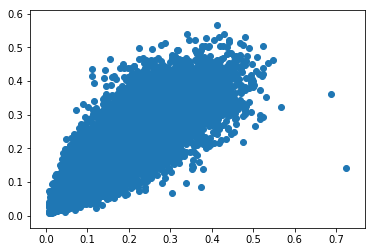

In [43]:
plt.scatter(y1, y2)

In [33]:
from scipy.stats import spearmanr

In [44]:
spearmanr(y1, y2)

SpearmanrResult(correlation=0.9286051208805963, pvalue=0.0)

In [73]:
hosp = hosp_cat[666]

In [84]:
hosp = 12245

In [85]:
hosp_dict[hosp]

360

In [86]:
sum(index_df.HOSP_NRD==hosp)

182

In [88]:
hosp_array_index = np.repeat(hosp_dict[hosp], len(index_df))

In [91]:
model.load_weights(model_path+'testing/inf_temp2.h5')

In [92]:
y_pred_index2 = model.predict([DX1_array_index, DX_mat_index, PR_mat_index, hosp_array_index, other_mat_index], verbose=1)

28090/28090 [==============================] - 1s 40us/step


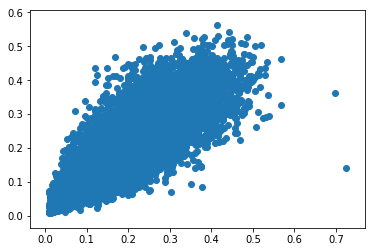

In [93]:
plt.scatter(y_pred_index1, y_pred_index2)

In [94]:
spearmanr(y_pred_index1, y_pred_index2)

SpearmanrResult(correlation=0.9322984959310859, pvalue=0.0)

In [48]:
recycle_pred = np.zeros((len(hosp_cat), ))
for i, hosp in enumerate(hosp_cat):
    hosp_array_index = np.repeat(hosp_dict[hosp], len(index_df))
    y_pred_index = model.predict([DX1_array_index, DX_mat_index, PR_mat_index, hosp_array_index, other_mat_index], verbose=0)
    recycle_pred[i] = y_pred_index.mean()
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [49]:
recycle_pred1 = recycle_pred.copy()

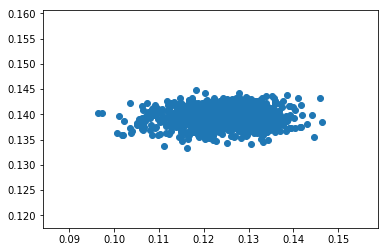

In [50]:
plt.scatter(recycle_pred1, recycle_pred2)

In [51]:
spearmanr(recycle_pred1, recycle_pred2)

SpearmanrResult(correlation=0.043557832276792385, pvalue=0.19827236196341336)